# Image Generation

## 1.1 Generative adversarial network
#### In this exercise, you will implement a Deep Convolutional Generative Network (DCGAN) to synthesis images by using the provided anime faces dataset.

---


- Construct a <font color=red>$\text{DCGAN}$</font> with GAN objective, you can refer to the [tutorial website](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) provided by PyTorch} for implementation.
    \begin{equation*} \begin{aligned}
    &\max _{D} \mathcal{L}(D) =\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}} \log D(\boldsymbol{x})+\mathbb{E}_{z \sim p_{\boldsymbol{z}}} \log (1-D(G(\boldsymbol{z}))) \\
    &\min _{G} \mathcal{L}(G) =\mathbb{E}_{z \sim p_{x}} \log (1-D(G(\boldsymbol{z}))
    \end{aligned} \end{equation*}
- <font color=red>Draw</font> some samples generated from your generator at <font color=red>different training stages </font>. For example, you may show the results when running at $5^{\text{th}}$ and final epoch 100. (10\%)


<img src="https://i.imgur.com/tnRR3tr.png" width="350px" />
<img src="https://i.imgur.com/g9AnDwN.png" width="350px" />





In [3]:
# Downlaod and unzip data
!gdown 1K1oB7GOUerTCIa68bbxETcGajLeE_5j1
!unzip resized_64x64.zip

### Please write the gan code here

In [8]:
# Please write the gan code here
# Note: In our experience, you can just select around 10000 images for training and get acceptable result.
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


# Set random seed for reproducibility
# manualSeed = 999
manualSeed = random.randint(1, 10000)
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Run on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device) 

#　Parameters
workers = 2 # number of worker for DataLoader.
batch_size = 256
image_size = 64 # All images will be resized to this size.
nz = 100 # size of generator input
num = 30000 # Number of training pictures

# Dataset
train_img = np.zeros((num, 64, 64, 3))
sample = random.sample(range(63565), num)

def copy_img():
    for i in range(num):
        shutil.copy("./resized_64x64/" + str(sample[i]) + ".jpg", "./img_class/img/" + str(sample[i]) + ".jpg")

if not os.path.exists("./img_class/img"):
    os.mkdir("./img_class/img")
    copy_img()
else:
    shutil.rmtree("./img_class/img")
    os.mkdir("./img_class/img")
    copy_img()

# for i in range(num):
#     train_img[i] = cv2.imread("./img/resized_64x64/" + str(i) + ".jpg")
#     # print(train_img[i].shape)

stats = ((train_img[:, :, :, 0].mean(), train_img[:, :, :, 1].mean(), train_img[:, :, :, 2].mean()), 
        (train_img[:, :, :, 0].std(), train_img[:, :, :, 1].std(), train_img[:, :, :, 2].std()))

# for i in range(num):
#     train_img[i] = Image.fromarray(np.uint8(train_img[i]))
#     print(type(train_img[i]))

train_tfms = tt.Compose([
        # tt.ToPILImage(),
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        # tt.Normalize(mean = stats[0], std = stats[1])
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

# print(type(train_img))
dataset = ImageFolder(root = "./img_class", transform = train_tfms)

dataloader = DataLoader(dataset = dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = workers)

# Plot some training images to check data is correctly loaded
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8, 8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[: 64], padding = 2, normalize = True).cpu(), (1, 2, 0)))


In [9]:
# Weight Initial
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(w.weight.data, mean = 0.0, std = 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(w.weight.data, mean = 1.0, std = 0.02)
        nn.init.constant_(w.bias.data, val = 0)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.relu = nn.ReLU(inplace = True)
        self.Tanh = nn.Tanh()
        self.convT_1 = nn.ConvTranspose2d(nz, 64 * 8, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.norm_1 = nn.BatchNorm2d(64 * 8)
        self.convT_2 = nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_2 = nn.BatchNorm2d(64 * 4)
        self.convT_3 = nn.ConvTranspose2d(64 * 4, 64 * 2, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_3 = nn.BatchNorm2d(64 * 2)
        self.convT_4 = nn.ConvTranspose2d(64 * 2, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_4 = nn.BatchNorm2d(64)
        self.convT_5 = nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False)

    def forward(self, data):
        data = self.convT_1(data)
        data = self.norm_1(data)
        data = self.relu(data)
        data = self.convT_2(data)
        data = self.norm_2(data)
        data = self.relu(data)
        data = self.convT_3(data)
        data = self.norm_3(data)
        data = self.relu(data)
        data = self.convT_4(data)
        data = self.norm_4(data)
        data = self.relu(data)
        data = self.convT_5(data)
        data = self.Tanh(data)
        return data

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.relu = nn.LeakyReLU(0.2, inplace = True)
        self.sigmoid = nn.Sigmoid()
        self.conv_1 = nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_2 = nn.Conv2d(64, 64 * 2, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_2 = nn.BatchNorm2d(64 * 2)
        self.conv_3 = nn.Conv2d(64 * 2, 64 * 4, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_3 = nn.BatchNorm2d(64 * 4)
        self.conv_4 = nn.Conv2d(64 * 4, 64 * 8, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.norm_4 = nn.BatchNorm2d(64 * 8)
        self.conv_5 = nn.Conv2d(64 * 8, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)

    def forward(self, data):
        data = self.conv_1(data)
        data = self.relu(data)
        data = self.conv_2(data)
        data = self.norm_2(data)
        data = self.relu(data)
        data = self.conv_3(data)
        data = self.norm_3(data)
        data = self.relu(data)
        data = self.conv_4(data)
        data = self.norm_4(data)
        data = self.relu(data)
        data = self.conv_5(data)
        data = self.sigmoid(data)
        return data
    
# Training
img_list = []
Gloss = []
Dloss = []
number = 10
epochs = 100
lr = 1e-3


# Create Model    
modelG = Generator().to(device)
modelG.apply(weights_init)
# print(modelG)

modelD = Discriminator().to(device)
modelD.apply(weights_init)
# print(modelD)

# LOSS
loss = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device = device)
real = 1.0
fake = 0.0

# Optimizer
optimD = torch.optim.Adam(params = modelD.parameters(), lr = lr, betas = (0.5, 0.999))
optimG = torch.optim.Adam(params = modelG.parameters(), lr=lr, betas = (0.5, 0.999))

def Train(img_list = img_list, Gloss = Gloss, Dloss = Dloss, modelD = modelD, modelG = modelG, loss = loss, optimnizerD = optimD, optimizerG = optimG, epochs = epochs, number = number, dataloader = dataloader):
    for epoch in range(epochs):
        for index, data in enumerate(dataloader, 0):
            # Update Discriminator
            # argmax(log(D(x)) + log(1 - D(G(z))))
            modelD.zero_grad()
            real_data = data[0].to(device)
            label = torch.full((real_data.size(0), ), fill_value = real, dtype = torch.float, device = device)
            # Forward
            y = modelD.forward(real_data).view(-1)
            lossD_real = loss(y, label)
            # Calculate Gradients with Backward
            lossD_real.backward()
            D_x = y.mean().item()

            # Train Fake Images
            noise = torch.randn(real_data.size(0), nz, 1, 1, device = device)
            # Generate batch of latent vector
            fake_data = modelG.forward(noise)
            label.fill_(fake)
            y = modelD.forward(fake_data.detach()).view(-1)
            # Calculate Discriminator Loss
            lossD_fake = loss(y, label)
            # Calculate Gradients with Backward
            lossD_fake.backward()
            D_G_z1 = y.mean().item()
            lossD = lossD_real + lossD_fake
            optimnizerD.step()

            # Update Generator
            # argmin(1 - logD(G(z))) or argmax(logD(G(z)))
            modelG.zero_grad()
            label.fill_(real) # Use real label for Generator to use log(D(G(z))) part of BCELoss
            y = modelD.forward(fake_data).view(-1)
            # Calculate Generator Loss Base on this Output
            lossG = loss(y, label)
            lossG.backward()
            D_G_z2 = y.mean().item()
            optimizerG.step()

            # Training Profile
            # if index % number == 0:
            #     print("Epoch:[%d/%d] Batch:[%d/%d]\tLossD: %.4f\tLossG: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
            #       % (epoch + 1, epochs, index, len(dataloader), lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

            # Save Loss
            Gloss.append(lossG.item())
            Dloss.append(lossD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if ((epoch + 1) % 5 == 0):
            with torch.no_grad():
                fake_data = modelG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding = 2, normalize = True))

def plot():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss")
    plt.plot(Gloss, label = "Generator")
    plt.plot(Dloss, label = "Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# matplotlib.rcParams['animation.embed_limit'] = 2**128
def plot_pic(num):
    # Plot the fake images from each epoch
    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title("Training For %d Epochs" %(num), fontsize = 15)
    plt.imshow(np.transpose(img_list[round(num / 5) - 1], (1, 2, 0)))
    plt.show()

### 1.1.a 
### Draw some samples generated from your generator at different training stages. For example, you may show the results when running at 5th and final epoch 100

START TRAINING:


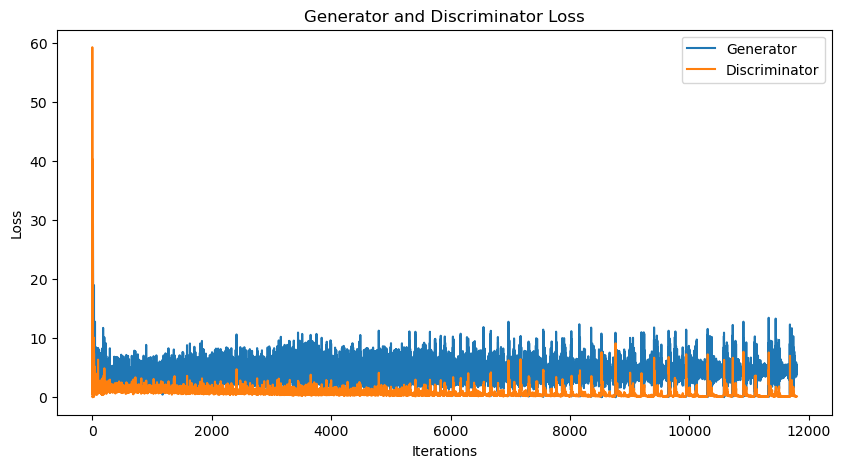

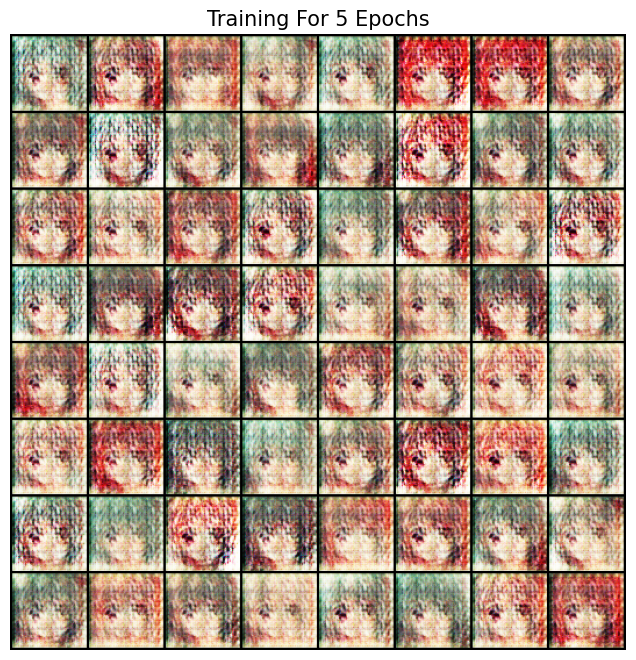

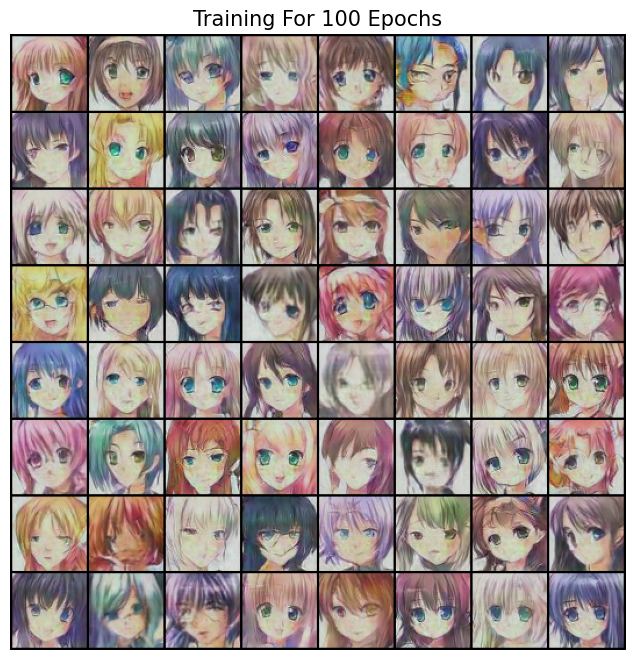

In [10]:
# Training Start
print("START TRAINING:")
Train()
plot()
plot_pic(5)
plot_pic(100)

### 1.1.b
### The Helvetica Scenario often happens during the training procedure of GAN. Please explain why this problem occurs and how to avoid it. We suggest you can read the original paper and do the discuss.


Why this problem occur:

Model Collapse is a common problem when training generative adversarial networks, this happens when the generator fails to generates data samples that are as diverse as the distribution of the real data and all of the generated samples are very similar or even identical(means that the generator learns to map different z to the same x).

How to avid it:
1. The Wasserstein loss formulates the GAN loss functions to more directly represent minimizing the distance between two probability distributions. 
2. Updating the generator’s loss function to backpropagate through k steps of gradient updates for the discriminator.
3. Modifying the discriminator to make decisions based on multiple samples all of the same class–either real or artificial. 

## 1.2 Denoising Diffusion Probabilistic Model (30%)

#### In this exercise, you will implement a <font color=red>Denoising Diffusion Probabilistic Model (DDPM) </font>to generate images by the provided  <font color=red>anime faces dataset</font>. The Figure below is the process of the Diffusion Model. It consists of a forward process, which gradually adds noise, and the reverse process will transform the noise back into a sample from the target distribution. Here is the [link1](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) and [link2](https://www.youtube.com/watch?v=azBugJzmz-o&t=190s) to the detailed introduction to the diffusion model. 

<img src="https://i.imgur.com/BqpRi4v.png"/>

1. Construct  <font color='blue'>DDPM</font> by fulfilling the <font color='red'>2 TODOs</font> and follow the instruction. Noticed that you are not allowed to directly call library or API to load the model. The total epoch is 10. (20\%)

  (a) **Draw** some generated samples based on diffusion steps $T = 500$ and $T = 1000$. We provide the **pre-trained weights** which are trained with 500 and 1000 steps. Hint: In the paper, the steps start at 1..

  (b) **Discuss** the result based on different diffusion steps.

### Training (You can skip this)

- Notice that becuase the diffusion requires high computational device, Colab may not be suitable. Thus, we provide the code of Training for reference. 

In [ ]:
!pip install torchmetrics

In [8]:
import torch, sys
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm, trange
from model import Unet
from torchmetrics import MeanMetric
from dataloader import get_loader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) # make sure this is cuda

cuda


In [10]:
T = 500
ALPHA = 1-torch.linspace(1e-4, 2e-2, T)
def alpha(t):
    at = torch.prod(ALPHA[:t]).reshape((1, ))
    return torch.sqrt(torch.cat((at, 1-at)))
ALPHA_bar = torch.stack([alpha(t) for t in range(T)]).to(device)

batch_size = 64
update_step = 1
save_step = 2
save_step_ = 20
num_workers = 6
epochs = 100
loss_func = torch.nn.MSELoss()
lr = 5e-4
model = Unet(
    in_channels=3
)
# state_dict = torch.load('checkpoint.pth')
state_dict = torch.load('checkpoint_100epoch_T1000.pth')
optimizer = Adam(model.parameters(), lr = lr)
scheduler = StepLR(optimizer, step_size = 10, gamma = 0.5)

In [11]:
def train(model, data_loader):
    running_loss = MeanMetric(accumulate = True)

    model.train()
    optimizer.zero_grad()

    for epoch in (overall:=trange(1, epochs + 1, position = 1, desc = '[Overall]')):
        running_loss.reset()

        for i, X_0 in enumerate(bar := tqdm(data_loader, position=0, desc=f'[Train {epoch:3d}] lr={scheduler.get_last_lr()[0]:.2e}'), start = 1):
            X_0 = X_0.to(device)
            eps = torch.randn(X_0.shape, device = device)
            # print(X_0.shape)
            t = torch.randint(0, T, (X_0.shape[0], ), device = device)

            # print(ALPHA_bar[t, 0].reshape(-1, 1, 1, 1)*X_0)
            with torch.no_grad():
                X_noise = ALPHA_bar[t, 0].reshape(-1, 1, 1, 1)*X_0 + ALPHA_bar[t, 1].reshape(-1, 1, 1, 1)*eps
            # X_noise = X_noise.to(device)
            t = t.to(device)
            
            pred = model(X_noise, t+1)

            loss = loss_func(eps, pred)
            loss.backward()

            if i % update_step == 0 or i == bar.total:
                optimizer.step()
                optimizer.zero_grad()

            running_loss.update(loss.item())
            bar.set_postfix_str(f'loss {running_loss.compute():.2e}')

        scheduler.step()
        tqdm.write('\r\033[K', end='')

        if epoch % save_step == 0:
            save_checkpoint(epoch, model, optimizer, 'checkpoint.pth')
        if epoch % save_step_ == 0:
            save_checkpoint(epoch, model, optimizer, f'checkpoint_{epoch}.pth')    

def save_checkpoint(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, path)
    tqdm.write('Save checkpoint')

In [ ]:
# Training start
train_loader = get_loader(
    'resized_64x64/',
    batch_size, 
    num_workers
)
model = model.to(device)
train(model, train_loader)

### Sampling

In [ ]:
!gdown 1n9K-HSY3GJKTS4HkHTCA_AJT0q1cKBZ1 
# checkpoint_epoch100_T1000.pth
!gdown 1jPycQFo_f_fPRUg6OuauTrsXbdibTvKI 
# checkpoint_epoch100_T500.pth

In [11]:
import gc
import torch, os
gc.collect()
torch.cuda.empty_cache()
from tqdm import trange, tqdm
from torchvision.utils import save_image
from torchvision.transforms import ColorJitter
import torch, sys
from tqdm import tqdm, trange
from model import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 
T = 1000   # 500 or 1000
model = Unet(in_channels=3).to(device)
state_dict = torch.load('checkpoint_100epoch_T1000.pth')
model.load_state_dict(state_dict['model_state_dict'])

cuda


<All keys matched successfully>

In [12]:
ALPHA = (1-torch.linspace(1e-4, 2e-2, T)).to(device)

@torch.no_grad()
def generate_and_save(model, gen_N, chan = 3, resolu = (28, 28)):
    model.eval()

    L = []
    X_T = torch.randn(size = (gen_N, chan, 64, 64), device = device)


    for t in (bar := trange(T-1, -1, -1)):
        bar.set_description(f'[Denoising] step: {t}')
        timestep = torch.tensor(t).to(device)

        def bond(consts, t_t):
            """Gather consts for t and reshape to feature map shape"""
            c = consts.gather(-1, t_t).to(device)
            return c.reshape(-1, 1, 1, 1)
        
        def p_xt(xt, noise, t_t):
            beta = torch.linspace(1e-4, 2e-2, T).to(device)
            alpha_bar = torch.cumprod(ALPHA, dim = 0)
            alpha_t = bond(ALPHA, t_t).to(device)
            alpha_bar_t = bond(alpha_bar, t_t).to(device)
            eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** 0.5
            mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
            var = bond(beta, t_t).to(device)
            # print(var)
            eps = torch.randn_like(xt).to(device) if t > 0 else 0
            return mean + (var ** 0.5) * eps 

        pred_noise = model(X_T, timestep.unsqueeze(0).to(device)).to(device)
        # print(pred_noise.shape)
        X_T = p_xt(X_T, pred_noise, timestep.unsqueeze(0).to(device)).to(device)

        if t < 1:
            L.append(X_T)

    save_image(torch.cat(L) / 2 + 0.5, 'L1000.jpg')

### 1.2.a 
#### **Draw** some generated samples based on diffusion steps $T = 500$ and $T = 1000$. We provide the **pre-trained weights** which are trained with 500 and 1000 steps. Hint: In the paper, the steps start at 1..

In [13]:
# gen_N is the setting of output images number
# resolu is the setting of output images resolution, you should not change this.
# This function will automatically save the sample images, what you need to do is to show in here.
generate_and_save(model, gen_N = 64, resolu = (64, 64))

[Denoising] step: 0: 100%|██████████| 1000/1000 [10:11<00:00,  1.64it/s] 


Generated Samples with T = 1000:


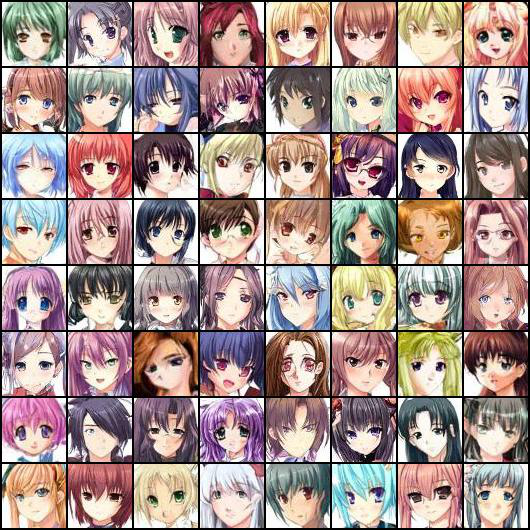

Generated Samples with T = 500:


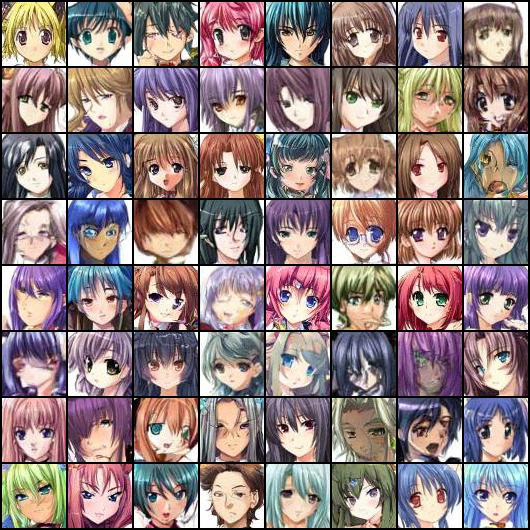

In [14]:
from PIL import Image 
print("Generated Samples with T = 1000:")
img1000 = Image.open("./L1000.jpg")
display(img1000)
print("=============================================")
print("Generated Samples with T = 500:")
img500 = Image.open("./L500.jpg")
display(img500)

### 1.2.b
#### **Discuss** the result based on different diffusion steps.

From the result, we can see that T = 1000 has higher quality than T = 500,and some of the faces in T = 500 are twisted, the reason is because pφ(x^T|z) gradually approaches to a standard Gaussian noise as T increases, and hence the combined model gradually matches the original DDPM as T increases.

## 1.3 Comparison between GAN and DDPM (10%)
#### (a) Both GAN and DDPM are generative models. The following figures are randomly generated results by using GAN (left) and DDPM (right). Please describe the pros and cons of the two models. (10%)

<img src="https://i.imgur.com/pU77cfa.jpg" width="600px"/>

### 1.3.a
### Both GAN and DDPM are generative models. The figures are randomly generated results by using GAN (left) and DDPM (right). Please describe the pros and cons of the two models based on your observation.

GAN:

(1)pros:
1. GANs are able to trade off diversity for fidelity, producing high quality samples but not covering the whole distribution.
2. Model architectures used by GANs literature have been heavily explored and refined.

(2)cons:
1. GANs are often difficult to train, collapsing without carefully selected hyperparameters and regularizers.
2. Some of the GANs model do not fully capture diversity.
3. GANs are difficult to scale and apply to new domains.
4. If the discriminator is too good, the generator training can fail due to the issue of vanishing gradients. 
5. Mode collapse.
6. GANs also have failure issue to converge.

DDPM:

(1)pros:
1. DDPM improve reliably with increased compute, and can produce high quality samples even on the difficult dataset using an upsampling stack.
2. Diffusion models are learned with a fixed procedure and the latent variable has high dimensionality.

(2)cons:
1. Slower than GANs at sampling time due to the use of multiple denoising steps.
2. Challenging to control DDPM to generate images with desired semantics.